# Virtual Acoustic Environments Spring 2022
## Project 9: Headphone Equalization using the Mean Square Error
**Author: Alpar Gür**

**Supervisor: David Bau**

**Professor: Christoph Pörschmann**

---
This notebook includes all necessary steps to create compensation filter for headphones.

Insert the impulse responses of desired headphones in the `sounds/impulse_responses/<headphone_name>/<pass0*.wav>`. 

`*` -> indicates the recording count. Total `recording_count` can be adjusted in the global parameters section.

Make sure that the sample rate of impulse response is 44100 Hz. And don't forget to add the headphone name in the `headphones` list below.

In [1]:
# import packages
import numpy as np
import sounddevice as sd
import soundfile as sf

from collections import defaultdict
from numpy import pi, abs, log10, ndarray, append, conj, convolve, roll
from numpy.fft import fft, ifft
from scipy.signal import butter, firwin, firwin2, unit_impulse, sosfilt, kaiserord, freqz
from shared.record_signal import convert_audio_to_numpy_array, play_sound
import matplotlib.pyplot as plt

import IPython.display as ipd
from scipy.io.wavfile import write

In [2]:
# define global parameters
fs = 44100
nyquist = fs / 2.0
n = 17640
n_one_sided = int(n / 2 + 1)
n_beats = 66150
n_beats_one_sided = int(n_beats / 2 + 1)
recording_count = 10
headphones = ['HD600', 'K601_001918', 'Beats_Detox']

### Get Headphone Recordings

Get Impulse Response (IR) for each Headphone

In [3]:
headphone_impulse_responses = defaultdict(dict)

for headphone in headphones:
    print(f"Headphone:\t {headphone}")

    for count in range(recording_count):
        impulse_response, fs = convert_audio_to_numpy_array(f"../sounds/impulse_responses/{headphone}/pass0{count}.wav")
        headphone_impulse_responses[headphone][count] = impulse_response
        
    headphone_impulse_responses[headphone]['fs'] = fs
    print(f'Sample Rate:\t {fs}')
    shape = headphone_impulse_responses[headphone][count].shape
    print(f'Shape:\t\t {shape}\n')

Headphone:	 HD600
Sample Rate:	 44100
Shape:		 (17640, 2)

Headphone:	 K601_001918
Sample Rate:	 44100
Shape:		 (17640, 2)

Headphone:	 Beats_Detox
Sample Rate:	 44100
Shape:		 (66150, 2)



Get Fourier Transform of IRs for each Headphone

In [4]:
def transform_impulse_responses_to_frequency_domain(recording):
    y_l = recording[:, 0]
    y_r = recording[:, 1]
    Y_L = fft(y_l)
    Y_R = fft(y_r)
    Y = append([Y_L], [Y_R], axis=0)
    Y = Y.transpose()
    return Y

In [5]:
headphone_impulse_responses_fft = defaultdict(dict)

for headphone in headphones:
    print(f"Headphone:\t {headphone}")

    for count in range(recording_count):
        headphone_impulse_responses_fft[headphone][count] = transform_impulse_responses_to_frequency_domain(headphone_impulse_responses[headphone][count])
    
    headphone_impulse_responses_fft[headphone]['fs'] = headphone_impulse_responses[headphone]['fs']
    print(f'Sample Rate:\t {fs}')
    shape = headphone_impulse_responses_fft[headphone][count].shape
    print(f'Shape:\t\t {shape}\n')

Headphone:	 HD600
Sample Rate:	 44100
Shape:		 (17640, 2)

Headphone:	 K601_001918
Sample Rate:	 44100
Shape:		 (17640, 2)

Headphone:	 Beats_Detox
Sample Rate:	 44100
Shape:		 (66150, 2)



Compute Complex Mean of Time Domain IRs for each Headphone

In [6]:
def get_complex_mean(audios, recording_count):
    n = audios[0].shape[0] # get audio length
    print(n)
    Y_L_sum = np.empty([n])
    Y_R_sum = np.empty([n])

    for inner_key in range(recording_count):
        Y_L_sum = Y_L_sum + audios[inner_key][:, 0]
        Y_R_sum = Y_R_sum + audios[inner_key][:, 1]

    Y_L_complex_mean = Y_L_sum / recording_count
    Y_R_complex_mean = Y_R_sum / recording_count
    Y_complex_mean = append([Y_L_complex_mean], [Y_R_complex_mean], axis = 0)
    Y_complex_mean = Y_complex_mean.transpose()

    return Y_complex_mean

In [7]:
headphone_complex_means = defaultdict(dict)

for headphone in headphones:
    print(f"Headphone:\t {headphone}")
    headphone_complex_means[headphone] = get_complex_mean(headphone_impulse_responses_fft[headphone], recording_count)
    shape = headphone_complex_means[headphone].shape
    print(f'Shape:\t\t {shape}')


Headphone:	 HD600
17640
Shape:		 (17640, 2)
Headphone:	 K601_001918
17640
Shape:		 (17640, 2)
Headphone:	 Beats_Detox
66150
Shape:		 (66150, 2)


Visualize Spectrum

In [8]:
def viz_spectrum(recording, n, ax1_title, ax2_title, title, fs=44100):
    f_vec = np.linspace(0, fs/2, n)
    left_channel = recording[:, 0][: n]
    right_channel = recording[:, 1][: n]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2), sharex=True)

    ax1.set_title(ax1_title)
    ax2.set_title(ax2_title)

    ax1.set_xlabel("Frequency [Hz]")
    ax2.set_xlabel("Frequency [Hz]")
    ax1.set_ylabel("Magnitude (dB)")

    ax1.semilogx(f_vec, 20*log10(abs(left_channel)))
    ax2.semilogx(f_vec, 20*log10(abs(right_channel)))

    ax1.set_xlim([20, fs/2])
    ax1.set_ylim(-60, 30)
    ax2.set_xlim([20, fs/2])
    ax2.set_ylim(-60, 30)

    ax1.grid(True)
    ax2.grid(True)

    fig.suptitle(title)
    fig.show()

/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_44030/41350975.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


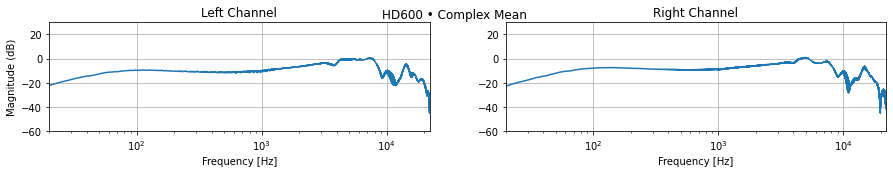

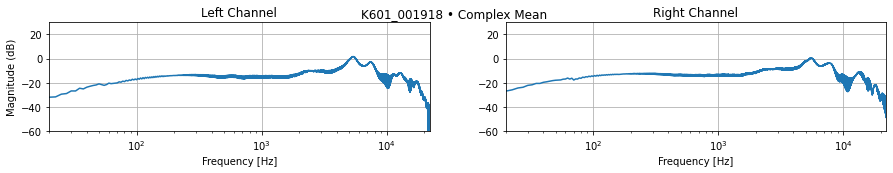

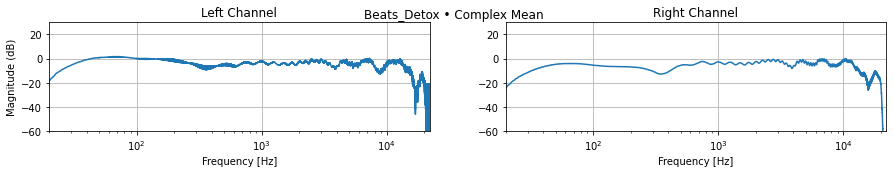

In [9]:
for headphone in headphones:
    window = n_one_sided
    if headphone == 'Beats_Detox':
        window = n_beats_one_sided
    viz_spectrum(headphone_complex_means[headphone], window, 'Left Channel', 'Right Channel', f'{headphone} • Complex Mean')

In [10]:
""" f_vec = np.linspace(0, fs/2, n_one_sided)
l1 = headphone_complex_means[headphones[0]][:, 0][: n_one_sided]
r1 = headphone_complex_means[headphones[0]][:, 1][: n_one_sided]

l2 = headphone_complex_means[headphones[1]][:, 0][: n_one_sided]
r2 = headphone_complex_means[headphones[1]][:, 1][: n_one_sided]

f_vec_beats = np.linspace(0, fs/2, n_beats_one_sided)
l3 = headphone_complex_means[headphones[2]][:, 0][: n_beats_one_sided]
r3 = headphone_complex_means[headphones[2]][:, 1][: n_beats_one_sided]

fig, (ax1) = plt.subplots(6, 1, figsize=(18, 32), sharex=True, sharey= True)

ax1[0].set_title(f'{headphones[0]} (Left Channel)', size = 36)
ax1[1].set_title(f'{headphones[0]} (Right Channel)', size = 36)
ax1[2].set_title(f'{headphones[1]} (Left Channel)', size = 36)
ax1[3].set_title(f'{headphones[1]} (Right Channel)', size = 36)
ax1[4].set_title(f'{headphones[2]} (Left Channel)', size = 36)
ax1[5].set_title(f'{headphones[2]} (Right Channel)', size = 36)

ax1[5].set_xlabel("Frequency [Hz]", size = 32)
ax1[0].set_ylabel("Magnitude [dB]", size = 32)
ax1[1].set_ylabel("Magnitude [dB]", size = 32)
ax1[2].set_ylabel("Magnitude [dB]", size = 32)
ax1[3].set_ylabel("Magnitude [dB]", size = 32)
ax1[4].set_ylabel("Magnitude [dB]", size = 32)
ax1[5].set_ylabel("Magnitude [dB]", size = 32)

ax1[0].semilogx(f_vec, 20*log10(abs(l1)))
ax1[2].semilogx(f_vec, 20*log10(abs(l2)))
ax1[4].semilogx(f_vec_beats, 20*log10(abs(l3)))
ax1[1].semilogx(f_vec, 20*log10(abs(r1)))
ax1[3].semilogx(f_vec, 20*log10(abs(r2)))
ax1[5].semilogx(f_vec_beats, 20*log10(abs(r3)))


ax1[0].set_xlim([20, fs/2])
ax1[1].set_ylim(-50, 10)
ax1[2].set_xlim([20, fs/2])
ax1[3].set_ylim(-50, 10)
ax1[4].set_xlim([20, fs/2])
ax1[5].set_ylim(-50, 10)

ax1[0].grid(True)
ax1[1].grid(True)
ax1[2].grid(True)
ax1[3].grid(True)
ax1[4].grid(True)
ax1[5].grid(True)
fig.show() """

' f_vec = np.linspace(0, fs/2, n_one_sided)\nl1 = headphone_complex_means[headphones[0]][:, 0][: n_one_sided]\nr1 = headphone_complex_means[headphones[0]][:, 1][: n_one_sided]\n\nl2 = headphone_complex_means[headphones[1]][:, 0][: n_one_sided]\nr2 = headphone_complex_means[headphones[1]][:, 1][: n_one_sided]\n\nf_vec_beats = np.linspace(0, fs/2, n_beats_one_sided)\nl3 = headphone_complex_means[headphones[2]][:, 0][: n_beats_one_sided]\nr3 = headphone_complex_means[headphones[2]][:, 1][: n_beats_one_sided]\n\nfig, (ax1) = plt.subplots(6, 1, figsize=(18, 32), sharex=True, sharey= True)\n\nax1[0].set_title(f\'{headphones[0]} (Left Channel)\', size = 36)\nax1[1].set_title(f\'{headphones[0]} (Right Channel)\', size = 36)\nax1[2].set_title(f\'{headphones[1]} (Left Channel)\', size = 36)\nax1[3].set_title(f\'{headphones[1]} (Right Channel)\', size = 36)\nax1[4].set_title(f\'{headphones[2]} (Left Channel)\', size = 36)\nax1[5].set_title(f\'{headphones[2]} (Right Channel)\', size = 36)\n\nax1[5

### Design Bandpass Filter

Bandpass Filter with Kaiser Windowing

In [11]:
# bandpass filter with kaiser window
lowcut_freq = 20.0 / nyquist
highcut_freq =20000.0 / nyquist
# desired width of the transition from pass to stop, relative to the Nyquist rate
width = 5.0 / nyquist
# desired attenuation in the stop band, in dB
ripple_db = 60.0
# compute the order and Kaiser parameter for the FIR filter
N, beta = kaiserord(ripple_db, width)
# cutoff frequency of the filter
cutoff_hz = 20.0
beta_kaiser = .1102*(ripple_db-8.7);

kaiser_taps = firwin(n+1, [lowcut_freq, highcut_freq], window=('kaiser', beta_kaiser), pass_zero='bandpass')
# convert to frequency domain
KAISER_TAPS = fft(kaiser_taps, n)

In [12]:
# bandpass filter for beats
kaiser_taps_beats = firwin(n_beats+1, [lowcut_freq, highcut_freq], window=('kaiser', beta_kaiser), pass_zero='bandpass')
# convert to frequency domain
KAISER_TAPS_BEATS = fft(kaiser_taps, n_beats)

In [13]:
def viz_filter(taps, n, filter_name):
    w, h = freqz(taps, worN=n)

    plt.plot((w/pi)*nyquist, abs(h), linewidth=2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.ylim(-0.05, 1.05)
    plt.title(f'Frequency Response of {filter_name}')
    plt.grid(True)
    plt.show()

In [14]:
#viz_filter(kaiser_taps, n, 'Bandpass Filter with Kaiser Window')

In [15]:
#viz_filter(kaiser_taps_beats, n_beats, 'Bandpass Filter with Kaiser Window')

FIR Bandpass Filter by pushing a Dirac Impulse through a Buttersworth SOS 

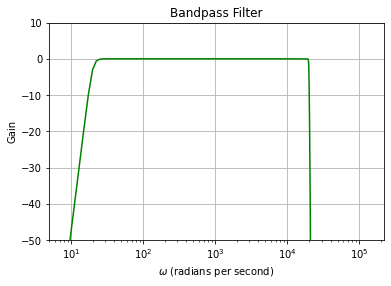

In [16]:
# filter parameters
highcut = 20000 
low_order = 8
lowcut = 20
high_order = 8

low_pass_filter = high_pass_filter = unit_impulse(n)

# lowpass
sos_low_pass = butter(low_order, highcut, 'lowpass', fs=fs, output='sos')
low_pass_filter = sosfilt(sos_low_pass, low_pass_filter)
low_pass_filter = fft(low_pass_filter)

# highpass
sos_hp = butter(high_order, lowcut, 'highpass', fs=fs, output='sos')
high_pass_filter = sosfilt(sos_hp, high_pass_filter)
high_pass_filter = fft(high_pass_filter)

bandlimit_filter = high_pass_filter * low_pass_filter

#plot
f_vec = np.linspace(0, fs/2, n_one_sided)
plt.semilogx(f_vec, 20*log10(abs(bandlimit_filter[: n_one_sided])), color='green')
plt.xlim([10/2, fs/2*10])
plt.ylim([-50, 10])

plt.xlabel('$\omega$ (radians per second)')
plt.ylabel('Gain')
plt.title('Bandpass Filter')
plt.grid(True)

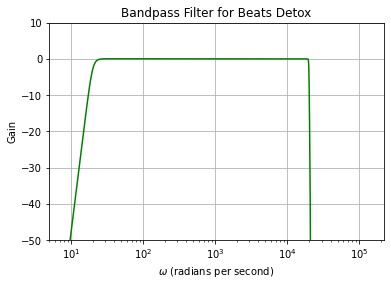

In [17]:
# bandpass for beats
low_pass_filter_beats = high_pass_filter_beats = unit_impulse(n_beats)

# lowpass
sos_low_pass_beats = butter(low_order, highcut, 'lowpass', fs=fs, output='sos')
low_pass_filter_beats = sosfilt(sos_low_pass_beats, low_pass_filter_beats)
low_pass_filter_beats = fft(low_pass_filter_beats)

# highpass
sos_hp_beats = butter(high_order, lowcut, 'highpass', fs=fs, output='sos')
high_pass_filter_beats = sosfilt(sos_hp_beats, high_pass_filter_beats)
high_pass_filter_beats = fft(high_pass_filter_beats)

bandlimit_filter_beats = high_pass_filter_beats * low_pass_filter_beats

#plot
f_vec = np.linspace(0, fs/2, n_beats_one_sided)
plt.semilogx(f_vec, 20*log10(abs(bandlimit_filter_beats[: n_beats_one_sided])), color='green')
plt.xlim([10/2, fs/2*10])
plt.ylim([-50, 10])

plt.xlabel('$\omega$ (radians per second)')
plt.ylabel('Gain')
plt.title('Bandpass Filter for Beats Detox')
plt.grid(True)

### Design Regularisation Filter

In [18]:
taps = 51
freqs = [0, 0.2, 0.6, 1]
gain = np.array([-20, -20, 0, 0]).astype(float)
linear_gain = 10**(gain/20)
#linear_gain[-1] = 0

b = firwin2(taps, freqs, linear_gain, window=('kaiser', 8))
B = fft(b, n)

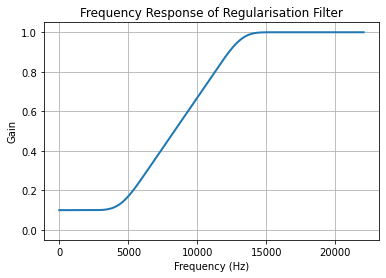

In [19]:
viz_filter(b, n, 'Regularisation Filter')

In [20]:
# regularisationi for beats
b_beats = firwin2(taps, freqs, linear_gain, window=('kaiser', 8))
B_BEATS = fft(b_beats, n_beats)

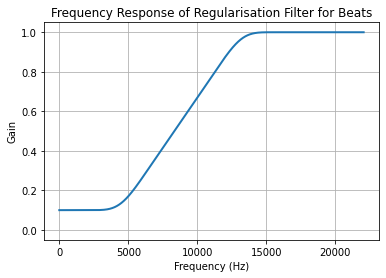

In [21]:
viz_filter(b_beats, n, 'Regularisation Filter for Beats')

### Calculate Inverse Filter in Frequency Domain

$hc = [H^{T}H + \beta B^{T}B] * H^{T}d$

$H_c(k) = \frac{D^{*}(k)H(k)}{H(k)H^{*}(k) + \beta \cdot B(k)B^{*}(k)}$

- $hc$ -> convolution matrice of measured transfer function
- $H$ -> convolution matrice of measured regularisation filter
- $B$ -> signal vector 
- $d$ -> signal vector (latter denoting the delayed IR of target bandpass filter)
- $\beta$ -> weighting regularisation filter

In [22]:
def filter_inverse(input_signal, bandpass_filter, regularisation_filter, beta: float = 0.4):
    Hc_L = bandpass_filter.transpose() * conj(input_signal[:, 0]).transpose() / \
        (input_signal[:, 0].transpose() * conj(input_signal[:, 0]) + beta * regularisation_filter.transpose() * conj(regularisation_filter.transpose()))
    Hc_R = bandpass_filter.transpose() * conj(input_signal[:, 1]).transpose() / \
        (input_signal[:, 1].transpose() * conj(input_signal[:, 1]) + beta * regularisation_filter.transpose() * conj(regularisation_filter.transpose()))
    output = np.append([Hc_L], [Hc_R], axis = 0)
    output = output.transpose()
    print(f"Shape:\t\t {output.shape}")

    return output

In [23]:
# using bandpass filter with Kaiser window
headphone_inversed_complex_means_kaiser = defaultdict(dict)

for headphone in headphones:
    print(f"Headphone:\t {headphone}")
    bandpass = KAISER_TAPS
    regularisation_filter = B
    if headphone == 'Beats_Detox':
        bandpass = KAISER_TAPS_BEATS
        regularisation_filter = B_BEATS
    headphone_inversed_complex_means_kaiser[headphone] = filter_inverse(headphone_complex_means[headphone], bandpass, regularisation_filter, beta=0.4)

Headphone:	 HD600
Shape:		 (17640, 2)
Headphone:	 K601_001918
Shape:		 (17640, 2)
Headphone:	 Beats_Detox
Shape:		 (66150, 2)


In [24]:
# with buttersworth bandpass filter
headphone_inversed_complex_means_buttersworth = defaultdict(dict)

for headphone in headphones:
    print(f"Headphone:\t {headphone}")
    bandpass = bandlimit_filter
    regularisation_filter = B
    if headphone == 'Beats_Detox':
        bandpass = bandlimit_filter_beats
        regularisation_filter = B_BEATS
    headphone_inversed_complex_means_buttersworth[headphone] = filter_inverse(headphone_complex_means[headphone], bandpass, regularisation_filter, beta=0.4)

Headphone:	 HD600
Shape:		 (17640, 2)
Headphone:	 K601_001918
Shape:		 (17640, 2)
Headphone:	 Beats_Detox
Shape:		 (66150, 2)


Visualize Signals Processed through Compensation Filter for each Headphone

/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_44030/41350975.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


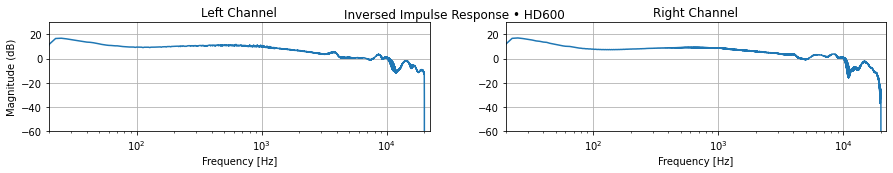

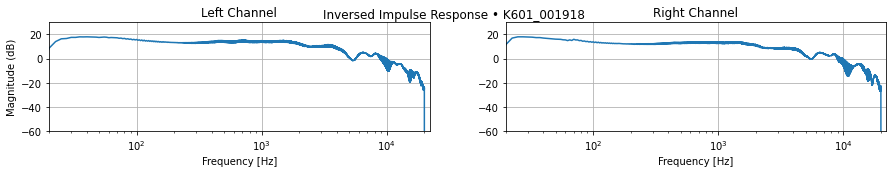

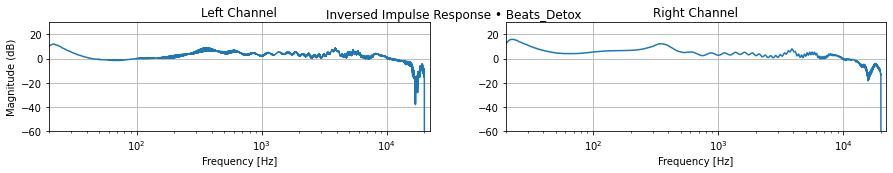

In [25]:
for headphone in headphones:
    window = n_one_sided
    if headphone == 'Beats_Detox':
        window = n_beats_one_sided
    viz_spectrum(headphone_inversed_complex_means_kaiser[headphone], window, 'Left Channel', 'Right Channel', f'Inversed Impulse Response • {headphone}')

In [26]:
""" f_vec = np.linspace(0, fs/2, n_one_sided)
l1 = headphone_inversed_complex_means_kaiser[headphones[0]][:, 0][: n_one_sided]
r1 = headphone_inversed_complex_means_kaiser[headphones[0]][:, 1][: n_one_sided]

l2 = headphone_inversed_complex_means_kaiser[headphones[1]][:, 0][: n_one_sided]
r2 = headphone_inversed_complex_means_kaiser[headphones[1]][:, 1][: n_one_sided]

f_vec_beats = np.linspace(0, fs/2, n_beats_one_sided)
l3 = headphone_inversed_complex_means_kaiser[headphones[2]][:, 0][: n_beats_one_sided]
r3 = headphone_inversed_complex_means_kaiser[headphones[2]][:, 1][: n_beats_one_sided]

fig, (ax1) = plt.subplots(6, 1, figsize=(18, 32), sharex=True, sharey= True)

ax1[0].set_title(f'{headphones[0]} (Left Channel)', size = 36)
ax1[1].set_title(f'{headphones[0]} (Right Channel)', size = 36)
ax1[2].set_title(f'{headphones[1]} (Left Channel)', size = 36)
ax1[3].set_title(f'{headphones[1]} (Right Channel)', size = 36)
ax1[4].set_title(f'{headphones[2]} (Left Channel)', size = 36)
ax1[5].set_title(f'{headphones[2]} (Right Channel)', size = 36)

ax1[5].set_xlabel("Frequency [Hz]", size = 32)
ax1[0].set_ylabel("Magnitude [dB]", size = 32)
ax1[1].set_ylabel("Magnitude [dB]", size = 32)
ax1[2].set_ylabel("Magnitude [dB]", size = 32)
ax1[3].set_ylabel("Magnitude [dB]", size = 32)
ax1[4].set_ylabel("Magnitude [dB]", size = 32)
ax1[5].set_ylabel("Magnitude [dB]", size = 32)

ax1[0].semilogx(f_vec, 20*log10(abs(l1)))
ax1[2].semilogx(f_vec, 20*log10(abs(l2)))
ax1[4].semilogx(f_vec_beats, 20*log10(abs(l3)))
ax1[1].semilogx(f_vec, 20*log10(abs(r1)))
ax1[3].semilogx(f_vec, 20*log10(abs(r2)))
ax1[5].semilogx(f_vec_beats, 20*log10(abs(r3)))


ax1[0].set_xlim([20, fs/2])
ax1[1].set_ylim(-50, 20)
ax1[2].set_xlim([20, fs/2])
ax1[3].set_ylim(-50, 20)
ax1[4].set_xlim([20, fs/2])
ax1[5].set_ylim(-50, 20)

ax1[0].grid(True)
ax1[1].grid(True)
ax1[2].grid(True)
ax1[3].grid(True)
ax1[4].grid(True)
ax1[5].grid(True)
fig.show() """

' f_vec = np.linspace(0, fs/2, n_one_sided)\nl1 = headphone_inversed_complex_means_kaiser[headphones[0]][:, 0][: n_one_sided]\nr1 = headphone_inversed_complex_means_kaiser[headphones[0]][:, 1][: n_one_sided]\n\nl2 = headphone_inversed_complex_means_kaiser[headphones[1]][:, 0][: n_one_sided]\nr2 = headphone_inversed_complex_means_kaiser[headphones[1]][:, 1][: n_one_sided]\n\nf_vec_beats = np.linspace(0, fs/2, n_beats_one_sided)\nl3 = headphone_inversed_complex_means_kaiser[headphones[2]][:, 0][: n_beats_one_sided]\nr3 = headphone_inversed_complex_means_kaiser[headphones[2]][:, 1][: n_beats_one_sided]\n\nfig, (ax1) = plt.subplots(6, 1, figsize=(18, 32), sharex=True, sharey= True)\n\nax1[0].set_title(f\'{headphones[0]} (Left Channel)\', size = 36)\nax1[1].set_title(f\'{headphones[0]} (Right Channel)\', size = 36)\nax1[2].set_title(f\'{headphones[1]} (Left Channel)\', size = 36)\nax1[3].set_title(f\'{headphones[1]} (Right Channel)\', size = 36)\nax1[4].set_title(f\'{headphones[2]} (Left Ch

/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_44030/41350975.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


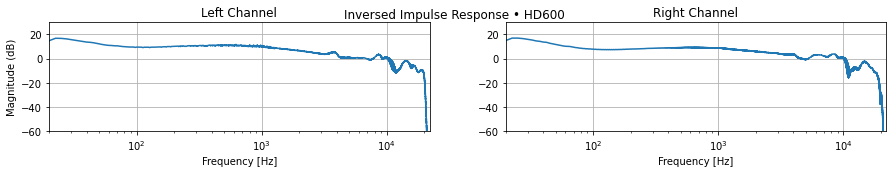

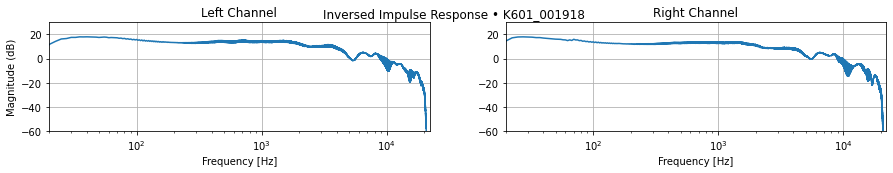

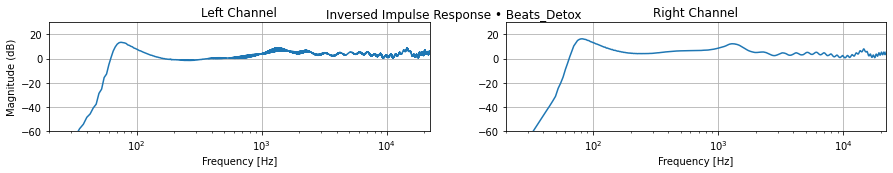

In [27]:
for headphone in headphones:
    window = n_one_sided
    if headphone == 'Beats_Detox':
        window = n_beats_one_sided
    viz_spectrum(headphone_inversed_complex_means_buttersworth[headphone], n_one_sided, 'Left Channel', 'Right Channel', f'Inversed Impulse Response • {headphone}')

In [85]:
""" f_vec = np.linspace(0, fs/2, n_one_sided)
l1 = headphone_inversed_complex_means_buttersworth[headphones[0]][:, 0][: n_one_sided]
r1 = headphone_inversed_complex_means_buttersworth[headphones[0]][:, 1][: n_one_sided]

l2 = headphone_inversed_complex_means_buttersworth[headphones[1]][:, 0][: n_one_sided]
r2 = headphone_inversed_complex_means_buttersworth[headphones[1]][:, 1][: n_one_sided]

f_vec_beats = np.linspace(0, fs/2, n_beats_one_sided)
l3 = headphone_inversed_complex_means_buttersworth[headphones[2]][:, 0][: n_beats_one_sided]
r3 = headphone_inversed_complex_means_buttersworth[headphones[2]][:, 1][: n_beats_one_sided]

fig, (ax1) = plt.subplots(6, 1, figsize=(18, 32), sharex=True, sharey= True)

ax1[0].set_title(f'{headphones[0]} (Left Channel)', size = 36)
ax1[1].set_title(f'{headphones[0]} (Right Channel)', size = 36)
ax1[2].set_title(f'{headphones[1]} (Left Channel)', size = 36)
ax1[3].set_title(f'{headphones[1]} (Right Channel)', size = 36)
ax1[4].set_title(f'{headphones[2]} (Left Channel)', size = 36)
ax1[5].set_title(f'{headphones[2]} (Right Channel)', size = 36)

ax1[5].set_xlabel("Frequency [Hz]", size = 32)
ax1[0].set_ylabel("Magnitude [dB]", size = 32)
ax1[1].set_ylabel("Magnitude [dB]", size = 32)
ax1[2].set_ylabel("Magnitude [dB]", size = 32)
ax1[3].set_ylabel("Magnitude [dB]", size = 32)
ax1[4].set_ylabel("Magnitude [dB]", size = 32)
ax1[5].set_ylabel("Magnitude [dB]", size = 32)

ax1[0].semilogx(f_vec, 20*log10(abs(l1)))
ax1[2].semilogx(f_vec, 20*log10(abs(l2)))
ax1[4].semilogx(f_vec_beats, 20*log10(abs(l3)))
ax1[1].semilogx(f_vec, 20*log10(abs(r1)))
ax1[3].semilogx(f_vec, 20*log10(abs(r2)))
ax1[5].semilogx(f_vec_beats, 20*log10(abs(r3)))


ax1[0].set_xlim([20, fs/2])
ax1[1].set_ylim(-50, 20)
ax1[2].set_xlim([20, fs/2])
ax1[3].set_ylim(-50, 20)
ax1[4].set_xlim([20, fs/2])
ax1[5].set_ylim(-50, 20)

ax1[0].grid(True)
ax1[1].grid(True)
ax1[2].grid(True)
ax1[3].grid(True)
ax1[4].grid(True)
ax1[5].grid(True)
fig.show() """

' f_vec = np.linspace(0, fs/2, n_one_sided)\nl1 = headphone_inversed_complex_means_buttersworth[headphones[0]][:, 0][: n_one_sided]\nr1 = headphone_inversed_complex_means_buttersworth[headphones[0]][:, 1][: n_one_sided]\n\nl2 = headphone_inversed_complex_means_buttersworth[headphones[1]][:, 0][: n_one_sided]\nr2 = headphone_inversed_complex_means_buttersworth[headphones[1]][:, 1][: n_one_sided]\n\nf_vec_beats = np.linspace(0, fs/2, n_beats_one_sided)\nl3 = headphone_inversed_complex_means_buttersworth[headphones[2]][:, 0][: n_beats_one_sided]\nr3 = headphone_inversed_complex_means_buttersworth[headphones[2]][:, 1][: n_beats_one_sided]\n\nfig, (ax1) = plt.subplots(6, 1, figsize=(18, 32), sharex=True, sharey= True)\n\nax1[0].set_title(f\'{headphones[0]} (Left Channel)\', size = 36)\nax1[1].set_title(f\'{headphones[0]} (Right Channel)\', size = 36)\nax1[2].set_title(f\'{headphones[1]} (Left Channel)\', size = 36)\nax1[3].set_title(f\'{headphones[1]} (Right Channel)\', size = 36)\nax1[4].s

Transfer Back to Time Domain

In [29]:
def transfer_inverse_function_to_time_domain(input_signal):
    hc_l = ifft(input_signal[:, 0])
    hc_r = ifft(input_signal[:, 1])
    hc = np.append([hc_l], [hc_r], axis=0)
    hc = hc.transpose()
    return hc

In [30]:
# for kaiser window
headphone_compensated_ir_kaiser = defaultdict(dict)

for headphone in headphones:
    print(f"Headphone:\t {headphone}")
    headphone_compensated_ir_kaiser[headphone] = transfer_inverse_function_to_time_domain(headphone_inversed_complex_means_kaiser[headphone])
    print(f"Shape:\t\t {headphone_compensated_ir_kaiser[headphone].shape}")

Headphone:	 HD600
Shape:		 (17640, 2)
Headphone:	 K601_001918
Shape:		 (17640, 2)
Headphone:	 Beats_Detox
Shape:		 (66150, 2)


In [31]:
# for kaiser buttersworth
headphone_compensated_ir_buttersworth = defaultdict(dict)

for headphone in headphones:
    print(f"Headphone:\t {headphone}")
    headphone_compensated_ir_buttersworth[headphone] = transfer_inverse_function_to_time_domain(headphone_inversed_complex_means_buttersworth[headphone])
    print(f"Shape:\t\t {headphone_compensated_ir_buttersworth[headphone].shape}")

Headphone:	 HD600
Shape:		 (17640, 2)
Headphone:	 K601_001918
Shape:		 (17640, 2)
Headphone:	 Beats_Detox
Shape:		 (66150, 2)


In [32]:
def viz_impulse_response(signal, n, ax1_title, ax2_title, title, fs: int = 44100):
    t_vec = np.arange(0, n) / fs
    left_channel = signal[:, 0][:n]
    right_channel = signal[:, 1][:n]

    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5), sharex='row', sharey='row')
    

    ax1.set_title(ax1_title)
    ax1.set_xlabel('Seconds')
    ax1.set_ylabel("Amplitude")


    ax2.set_title(ax2_title)
    ax2.set_xlabel('Seconds')
    ax2.set_ylabel("Amplitude")

    ax1.plot(t_vec, left_channel)
    ax2.plot(t_vec, right_channel)

    fig.suptitle(title, fontsize=16)

    ax1.grid(True)
    ax2.grid(True)
    fig.show()

/Users/alpargur/Library/Mobile Documents/com~apple~CloudDocs/Uni/Semester-2/VAE/Project/vae-22-project/venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_44030/491829305.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


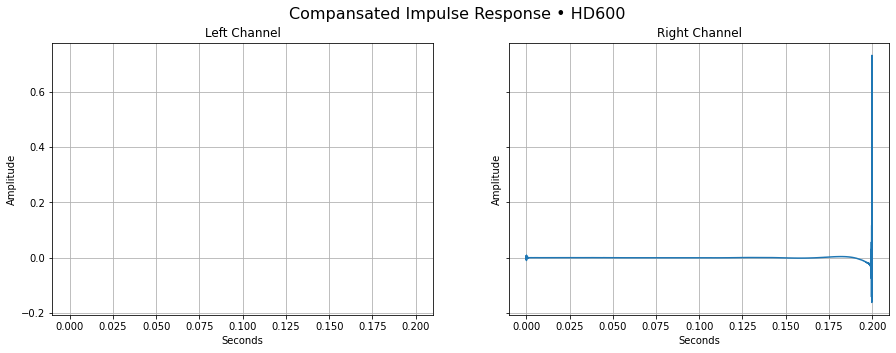

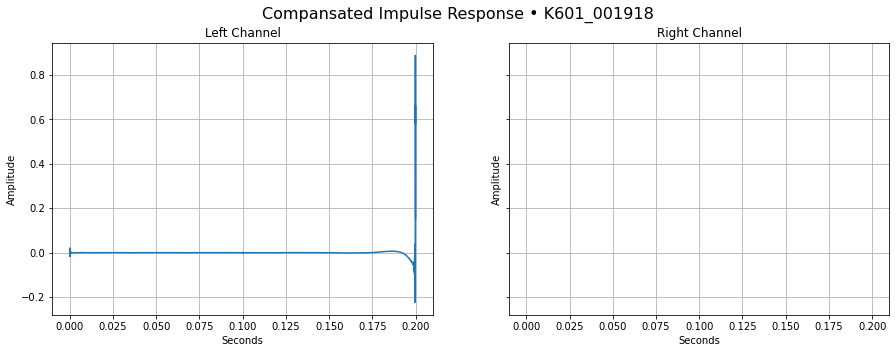

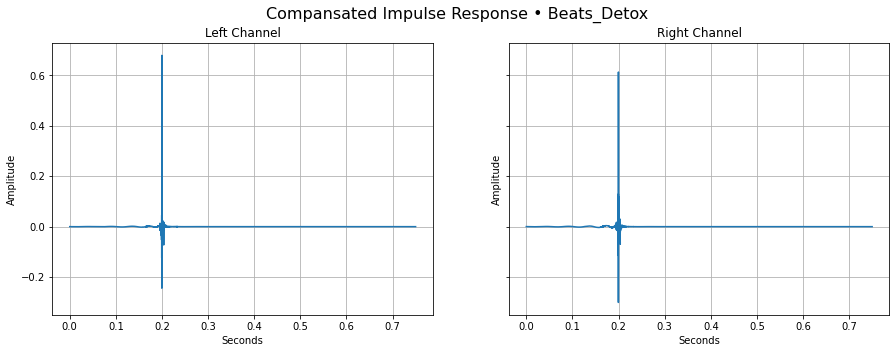

In [33]:
for headphone in headphones:
    window = n_one_sided
    if headphone == 'Beats_Detox':
        window = n_beats_one_sided
    viz_impulse_response(headphone_compensated_ir_kaiser[headphone], window, 'Left Channel', 'Right Channel', f'Compansated Impulse Response • {headphone}')

/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_44030/491829305.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


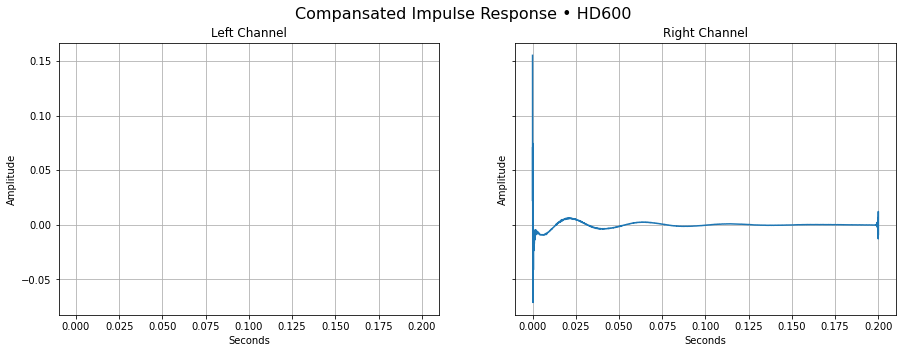

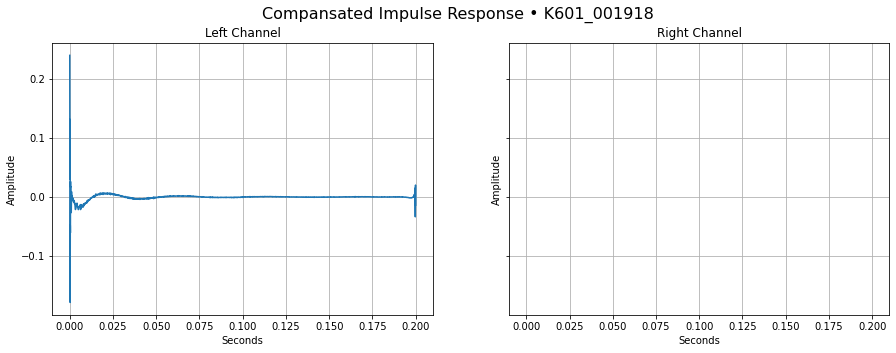

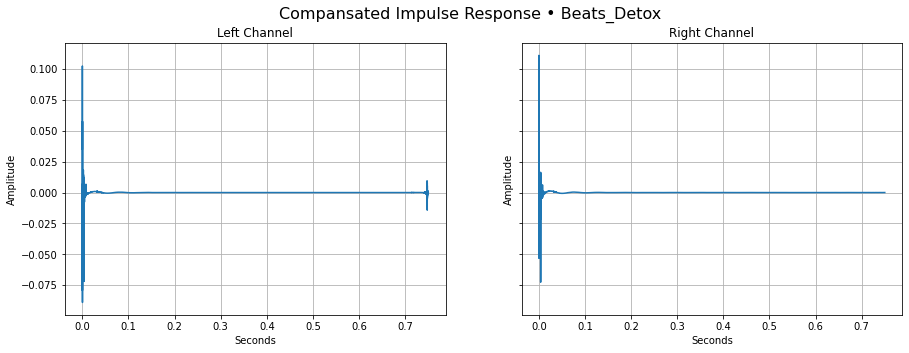

In [34]:
for headphone in headphones:
    window = n_one_sided
    if headphone == 'Beats_Detox':
        window = n_beats_one_sided
    viz_impulse_response(headphone_compensated_ir_buttersworth[headphone], window, 'Left Channel', 'Right Channel', f'Compansated Impulse Response • {headphone}')

Shift Signal and Cut Delay

In [35]:
def shift_and_cut_signal(input_signal, roll_distance, n):
    rolled_signal = roll(input_signal, roll_distance)
    shifted_signal_l = rolled_signal[:, 0][:n]
    shifted_signal_r = rolled_signal[:, 1][:n]
    output = append([shifted_signal_l], [shifted_signal_r], axis = 0)
    output = output.transpose()
    print(f'Shape:\t\t {output.shape}')
    return output


In [36]:
headphone_shifted_compensated_ir_kaiser = defaultdict(dict)

for headphone in headphones:
    print(f'Headphone:\t {headphone}')
    window = n_one_sided
    steps = n
    if headphone == 'Beats_Detox':
        window = n_beats_one_sided
        steps = -13200
    headphone_shifted_compensated_ir_kaiser[headphone] = shift_and_cut_signal(headphone_compensated_ir_kaiser[headphone], int(steps+160), window)

Headphone:	 HD600
Shape:		 (8821, 2)
Headphone:	 K601_001918
Shape:		 (8821, 2)
Headphone:	 Beats_Detox
Shape:		 (33076, 2)


In [37]:
#headphone_shifted_compensated_ir_kaiser['Beats_Detox'] = headphone_compensated_ir_kaiser['Beats_Detox']

/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_44030/491829305.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


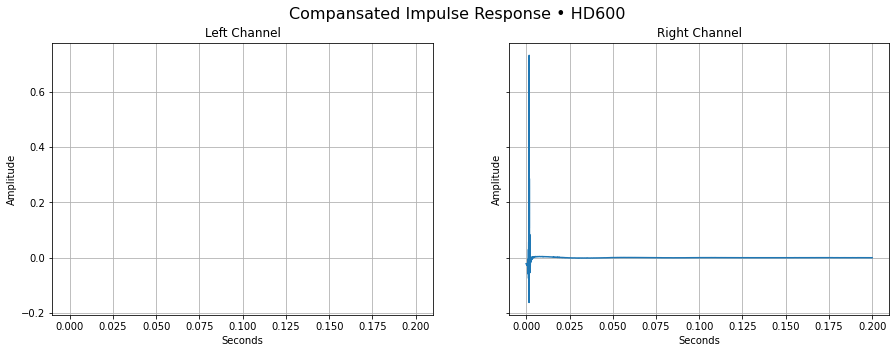

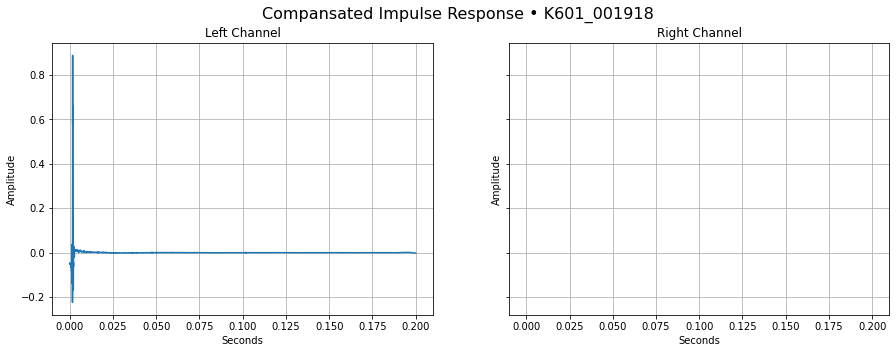

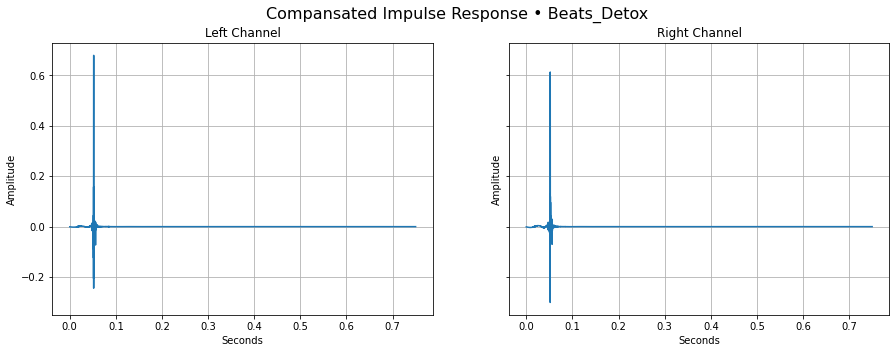

In [38]:
for headphone in headphones:
    window = n_one_sided
    if headphone == 'Beats_Detox':
        window = n_beats_one_sided
    viz_impulse_response(headphone_shifted_compensated_ir_kaiser[headphone], window, 'Left Channel', 'Right Channel', f'Compansated Impulse Response • {headphone}')

In [39]:
headphone_shifted_compensated_ir_buttersworth = defaultdict(dict)

for headphone in headphones:
    print(f'Headphone:\t {headphone}')
    window = n_one_sided
    steps = int(160)
    if headphone == 'Beats_Detox':
        window = n_one_sided
        steps = 0
    headphone_shifted_compensated_ir_buttersworth[headphone] = shift_and_cut_signal(headphone_compensated_ir_buttersworth[headphone], steps, window)

Headphone:	 HD600
Shape:		 (8821, 2)
Headphone:	 K601_001918
Shape:		 (8821, 2)
Headphone:	 Beats_Detox
Shape:		 (8821, 2)


In [40]:
#headphone_shifted_compensated_ir_buttersworth['Beats_Detox'] = headphone_compensated_ir_buttersworth['Beats_Detox']

/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_44030/491829305.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


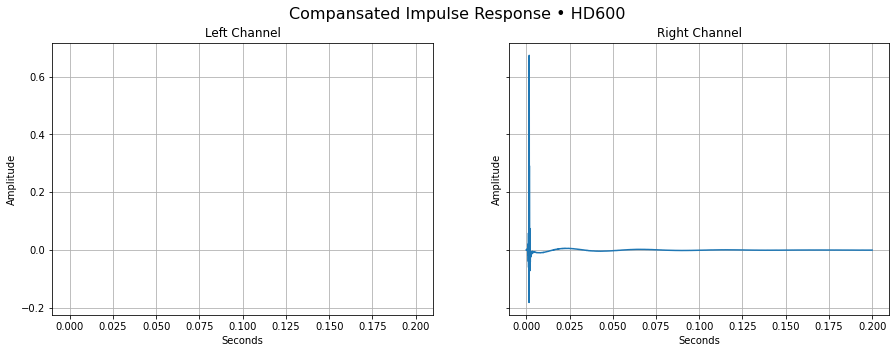

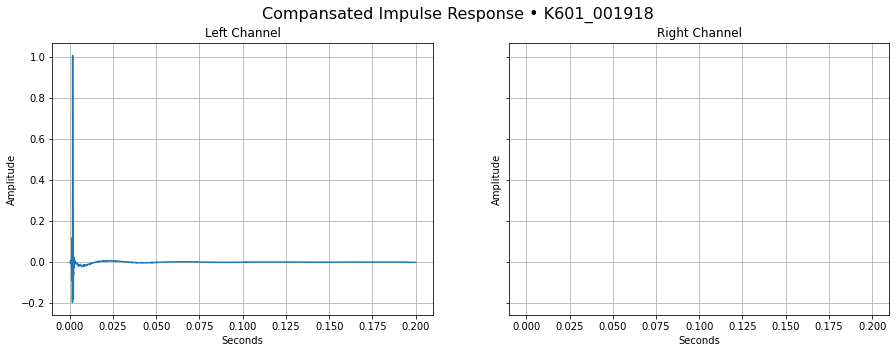

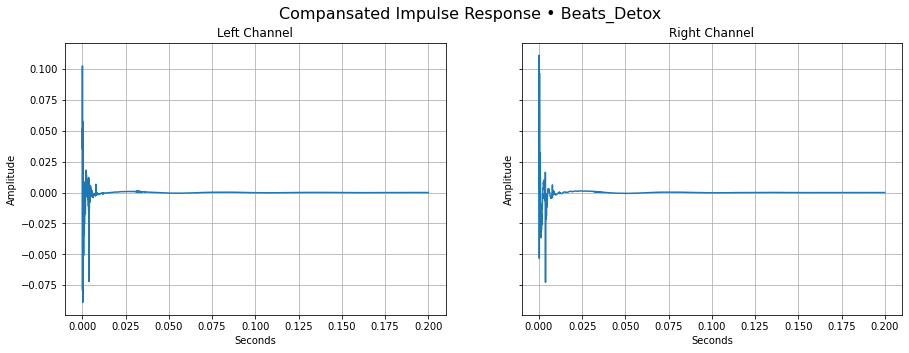

In [41]:
for headphone in headphones:
    window = n_one_sided
    if headphone == 'Beats_Detox':
        window = n_one_sided
    viz_impulse_response(headphone_shifted_compensated_ir_buttersworth[headphone], window, 'Left Channel', 'Right Channel', f'Compansated Impulse Response • {headphone}')

### Test the Filters

In [42]:
# import a drum loop
drum_loop, drum_fs = convert_audio_to_numpy_array(f"../sounds/loops/drum_loop_128_bpm.wav")
print(f'Shape:\t\t {drum_loop.shape}')
print(f'Sample Rate:\t {drum_fs}')

Shape:		 (330750, 2)
Sample Rate:	 44100


In [43]:
def convolve_sample_with_impulse_response(sample, impulse_response, fs):
    left_channel  = convolve(sample[:, 0], impulse_response[:, 0])
    right_channel  = convolve(sample[:, 1], impulse_response[:, 1])

    output = np.append([left_channel], [right_channel], axis = 0)
    output = output.transpose()
    output = output.astype('float32')

    return output

In [44]:
drum_loop_filtered_kaiser = defaultdict(dict)

for headphone in headphones:
    print(f"Headphone:\t {headphone}")
    drum_loop_filtered_kaiser[headphone] = convolve_sample_with_impulse_response(drum_loop, headphone_shifted_compensated_ir_kaiser[headphone], drum_fs)
    print(f"Shape:\t\t {drum_loop_filtered_kaiser[headphone].shape}")

Headphone:	 HD600


/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_44030/148840766.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  output = output.astype('float32')


Shape:		 (339570, 2)
Headphone:	 K601_001918
Shape:		 (339570, 2)
Headphone:	 Beats_Detox
Shape:		 (363825, 2)


In [45]:
drum_loop_filtered_buttersworth = defaultdict(dict)

for headphone in headphones:
    print(f"Headphone:\t {headphone}")
    drum_loop_filtered_buttersworth[headphone] = convolve_sample_with_impulse_response(drum_loop, headphone_shifted_compensated_ir_buttersworth[headphone], drum_fs)
    print(f"Shape:\t\t {drum_loop_filtered_buttersworth[headphone].shape}")

Headphone:	 HD600


/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_44030/148840766.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  output = output.astype('float32')


Shape:		 (339570, 2)
Headphone:	 K601_001918
Shape:		 (339570, 2)
Headphone:	 Beats_Detox
Shape:		 (339570, 2)


In [46]:
# import filters of erbes
def import_filter_of_erbes(path):
    filter, fs = convert_audio_to_numpy_array(path)
    return filter

In [47]:
erbes_filters = defaultdict(dict)

for headphone in headphones:
    print(f"Headphone:\t {headphone}")
    try:
        erbes_filters[headphone] = import_filter_of_erbes(f"../HPIRs_Erbes_44100Hz/compensation_filters/hpComp_{headphone}_1Filter.wav")
        print(f'Shape:\t\t {erbes_filters[headphone].shape}')
    except RuntimeError:
        print(f'Headhone {headphone} not found.')
        continue

Headphone:	 HD600
Shape:		 (2048, 2)
Headphone:	 K601_001918
Shape:		 (2048, 2)
Headphone:	 Beats_Detox
Headhone Beats_Detox not found.


In [48]:
drum_loop_filtered_erbes = defaultdict(dict)

for headphone in headphones:
    print(f"Headphone:\t {headphone}")
    try:
        drum_loop_filtered_erbes[headphone] = convolve_sample_with_impulse_response(drum_loop, erbes_filters[headphone], drum_fs)
        print(f'Shape:\t\t {drum_loop_filtered_erbes[headphone].shape}')
    except TypeError:
        print(f'No compatability with {headphone}.')
        continue

Headphone:	 HD600
Shape:		 (332797, 2)
Headphone:	 K601_001918
Shape:		 (332797, 2)
Headphone:	 Beats_Detox
No compatability with Beats_Detox.


### Listen to Audios

Headphone: HD600

In [49]:
erbes_hd600 = drum_loop_filtered_erbes['HD600']
kaiser_hd600 = drum_loop_filtered_kaiser['HD600']
buttersworth_hd600 = drum_loop_filtered_buttersworth['HD600']

In [66]:
# original audio
play_sound(drum_loop, drum_fs)

In [79]:
play_sound(erbes_hd600, drum_fs)

In [78]:
play_sound(kaiser_hd600/2, drum_fs)

In [77]:
play_sound(buttersworth_hd600/2, drum_fs)

Headphone: K601_001918

In [104]:
erbes_k601 = drum_loop_filtered_erbes['K601_001918']
kaiser_k601 = drum_loop_filtered_kaiser['K601_001918']
buttersworth_k601 = drum_loop_filtered_buttersworth['K601_001918']

In [105]:
play_sound(erbes_k601, drum_fs)

In [106]:
play_sound(kaiser_k601/2, drum_fs)

In [107]:
play_sound(buttersworth_k601/2, drum_fs)

Headphone: Beats Detox

In [80]:
kaiser_beats_detox = drum_loop_filtered_kaiser['Beats_Detox']
buttersworth_beats_detox = drum_loop_filtered_buttersworth['Beats_Detox']

In [81]:
# original audio
play_sound(drum_loop, drum_fs)

In [82]:
play_sound(kaiser_beats_detox/2, drum_fs)

In [83]:
play_sound(buttersworth_beats_detox/2, drum_fs)

In [89]:
 write(f"../sounds/exports/drum_loop_beats_filtered.wav", drum_fs, kaiser_beats_detox)

### Compare Filters

In [87]:
erbes_filters[headphones[0]][:, 1]

array([6.6041946e-05, 6.4849854e-05, 6.3180923e-05, ..., 6.6280365e-05,
       6.8545341e-05, 6.4969063e-05], dtype=float32)

In [88]:
hd600_erbes_l = erbes_filters[headphones[0]][:, 0]
hd600_erbes_r = erbes_filters[headphones[0]][:, 1]

hd600_erbes_L = fft(hd600_erbes_l)
hd600_erbes_R = fft(hd600_erbes_r)

n_erbes_one_sided = int(2048/2)+1

/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_44030/194126256.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


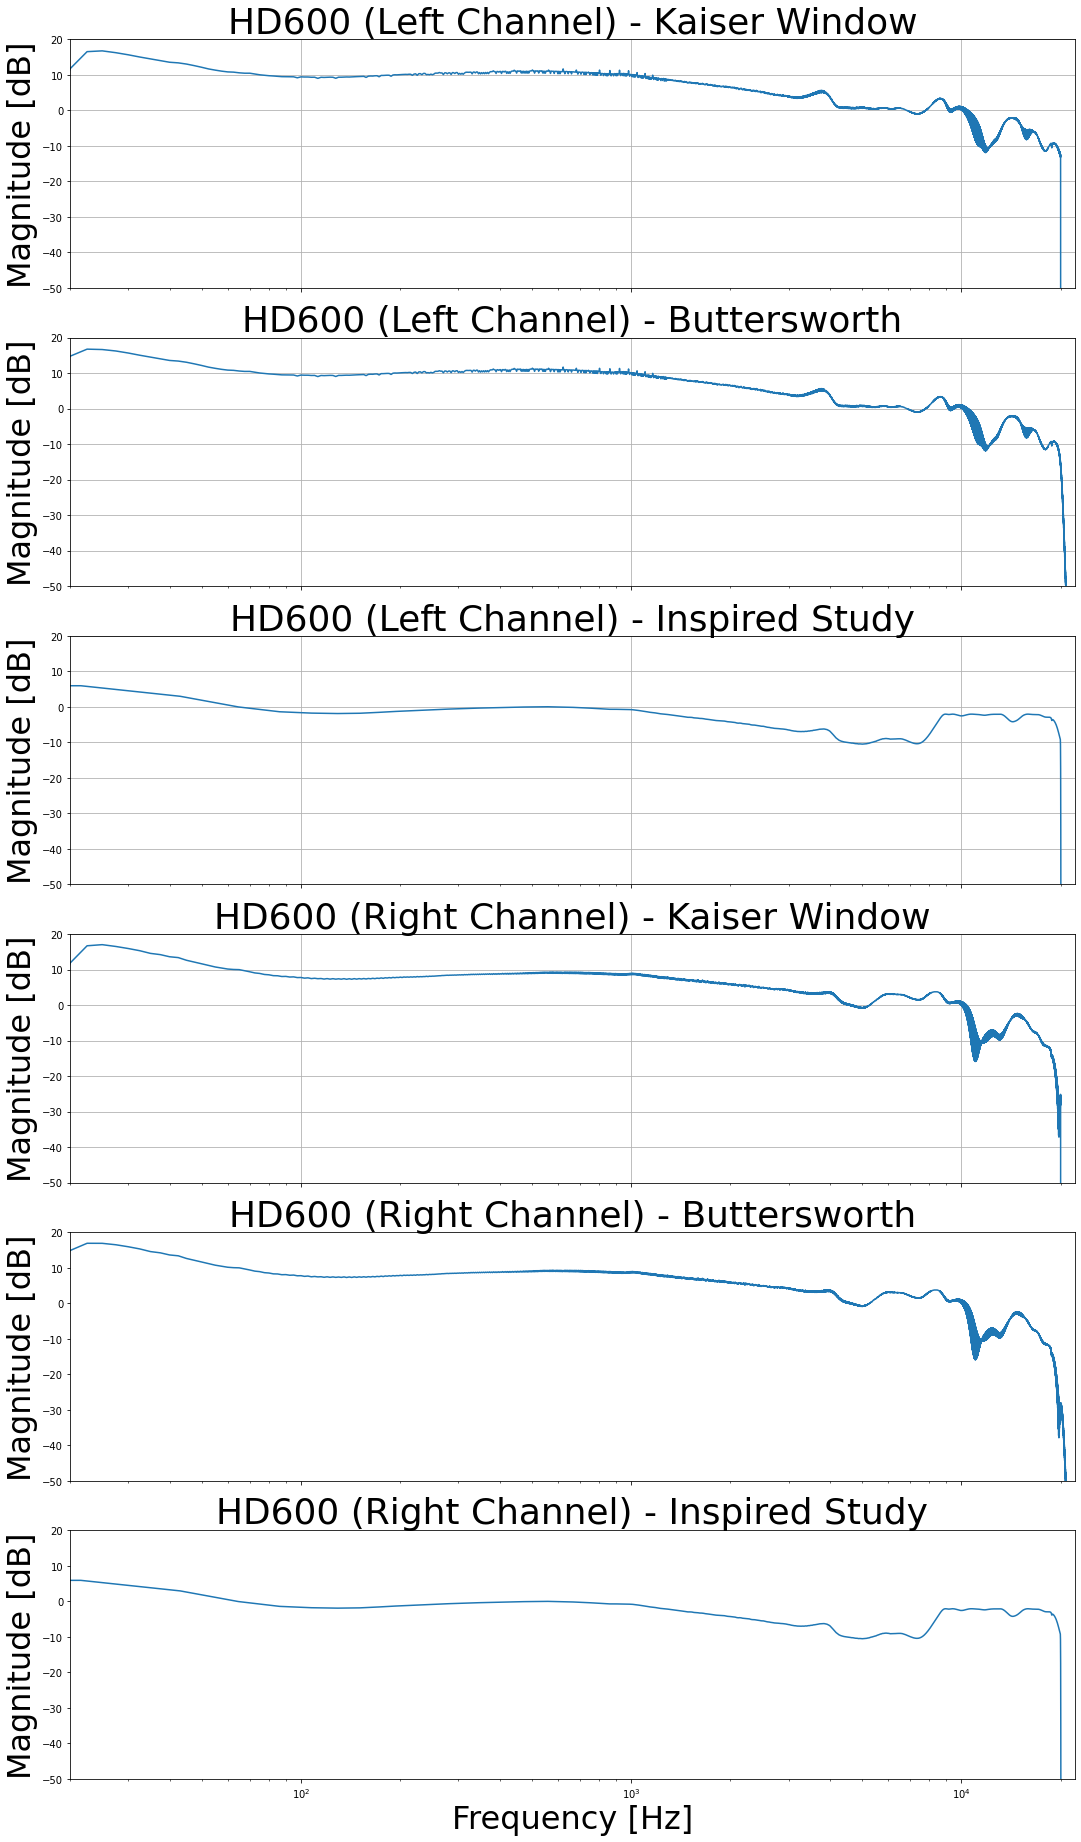

In [93]:
f_vec = np.linspace(0, fs/2, n_one_sided)
l1 = headphone_inversed_complex_means_kaiser[headphones[0]][:, 0][: n_one_sided]
r1 = headphone_inversed_complex_means_kaiser[headphones[0]][:, 1][: n_one_sided]

l2 = headphone_inversed_complex_means_buttersworth[headphones[0]][:, 0][: n_one_sided]
r2 = headphone_inversed_complex_means_buttersworth[headphones[0]][:, 1][: n_one_sided]

f_vec_erbes = np.linspace(0, fs/2, n_erbes_one_sided)
l3 = hd600_erbes_L[:n_erbes_one_sided]
r3 = hd600_erbes_R[:n_erbes_one_sided]


fig, (ax1) = plt.subplots(6, 1, figsize=(18, 32), sharex=True, sharey= True)

ax1[0].set_title(f'{headphones[0]} (Left Channel) - Kaiser Window', size = 36)
ax1[1].set_title(f'{headphones[0]} (Left Channel) - Buttersworth', size = 36)
ax1[2].set_title(f'{headphones[0]} (Left Channel) - Inspired Study', size = 36)
ax1[3].set_title(f'{headphones[0]} (Right Channel) - Kaiser Window', size = 36)
ax1[4].set_title(f'{headphones[0]} (Right Channel) - Buttersworth', size = 36)
ax1[5].set_title(f'{headphones[0]} (Right Channel) - Inspired Study', size = 36)

ax1[5].set_xlabel("Frequency [Hz]", size = 32)
ax1[0].set_ylabel("Magnitude [dB]", size = 32)
ax1[1].set_ylabel("Magnitude [dB]", size = 32)
ax1[2].set_ylabel("Magnitude [dB]", size = 32)
ax1[3].set_ylabel("Magnitude [dB]", size = 32)
ax1[4].set_ylabel("Magnitude [dB]", size = 32)
ax1[5].set_ylabel("Magnitude [dB]", size = 32)

ax1[0].semilogx(f_vec, 20*log10(abs(l1)))
ax1[1].semilogx(f_vec, 20*log10(abs(l2)))
ax1[2].semilogx(f_vec_erbes, 20*log10(abs(l3)))
ax1[3].semilogx(f_vec, 20*log10(abs(r1)))
ax1[4].semilogx(f_vec, 20*log10(abs(r2)))
ax1[5].semilogx(f_vec_erbes, 20*log10(abs(r3)))


ax1[0].set_xlim([20, fs/2])
ax1[1].set_ylim(-50, 20)
ax1[2].set_xlim([20, fs/2])
ax1[3].set_ylim(-50, 20)

ax1[0].grid(True)
ax1[1].grid(True)
ax1[2].grid(True)
ax1[3].grid(True)
fig.show()